# **HAR70+ Dataset: Data Preprocessing & Z-Score Normalization**
## **Step 1: Load & Normalize Each Subject's Data Individually**


In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load data
data_path = "har70plus"  
csv_files = [f for f in os.listdir(data_path) if f.endswith(".csv")]
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
normalized_data = []

# Process each subject file independently
for file in csv_files:
    subject_id = file.split(".")[0]  # Extract subject ID from filename
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["subject_id"] = subject_id     # Add subject_id as a new column
    
    # Apply Z-score normalization to sensors 
    scaler = StandardScaler()
    df[sensor_columns] = scaler.fit_transform(df[sensor_columns])
    normalized_data.append(df)


df_all_normalized = pd.concat(normalized_data, ignore_index=True)

# Checking 
df_all_normalized.head()


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject_id
0,2021-03-24 14:42:03.839,-0.346465,0.046882,0.344367,-0.310578,-0.078194,0.493743,6,501
1,2021-03-24 14:42:03.859,-0.291337,-0.076518,0.344367,-0.278401,-0.123405,0.487053,6,501
2,2021-03-24 14:42:03.880,-0.203269,-0.053734,0.344367,-0.258850,0.071362,0.458953,6,501
3,2021-03-24 14:42:03.900,-0.216874,0.081058,0.343782,-0.272292,0.234822,0.488838,6,501
4,2021-03-24 14:42:03.920,-0.268424,0.206355,0.349627,-0.304876,0.341479,0.532995,6,501


## **Step 2: Visualization**
Compare raw vs. normalized sensor readings for a sample subject.


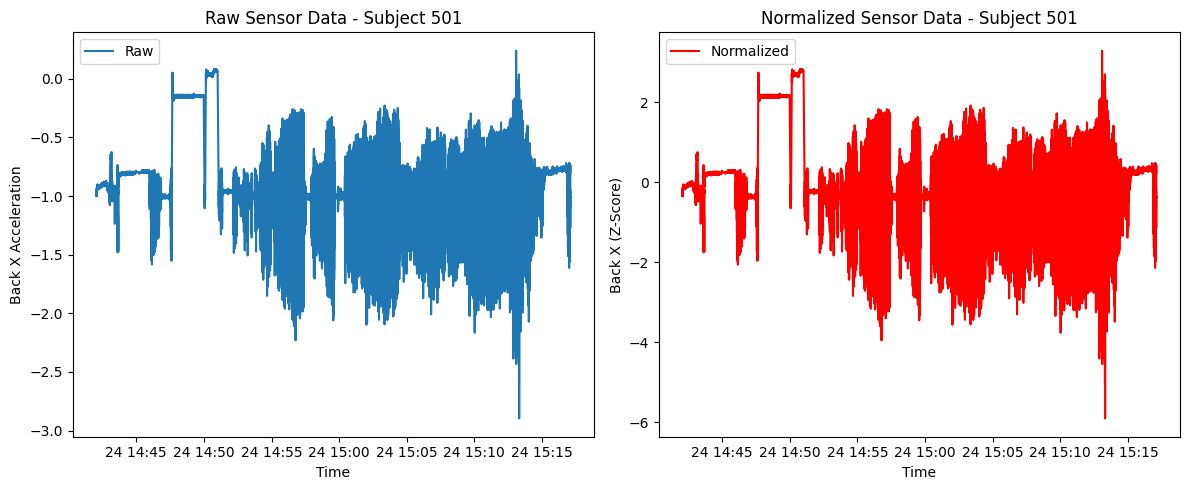

In [52]:
sample_subject = csv_files[0].split(".")[0]

raw_file_path = os.path.join(data_path, f"{sample_subject}.csv")
df_raw = pd.read_csv(raw_file_path)
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"])

df_norm = df_all_normalized[df_all_normalized["subject_id"] == sample_subject]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df_raw["timestamp"], df_raw["back_x"], label="Raw")
plt.title(f"Raw Sensor Data - Subject {sample_subject}")
plt.xlabel("Time")
plt.ylabel("Back X Acceleration")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_norm["timestamp"], df_norm["back_x"], label="Normalized", color='red')
plt.title(f"Normalized Sensor Data - Subject {sample_subject}")
plt.xlabel("Time")
plt.ylabel("Back X (Z-Score)")
plt.legend()

plt.tight_layout()
plt.show()


# **Step 3: Compute 30-Second Moving Averages**
## Why? To smooth data and analyze trends per activity.


In [53]:
window_size = 30  # Assuming data is sampled at 50Hz, this means 1500 samples per window, later we will move this down to 5 Hz

#Moving average per subject and label
df_smoothed = df_all_normalized.copy()
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
df_smoothed[sensor_columns] = df_all_normalized.groupby(['subject_id', 'label'])[sensor_columns].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

#Checking
df_smoothed.head()
# Verify the zero means 
print(df_all_normalized[sensor_columns].mean())
print(df_smoothed[sensor_columns].mean())

back_x     8.170812e-17
back_y    -2.817521e-17
back_z    -3.582277e-17
thigh_x   -3.059023e-17
thigh_y    1.549637e-17
thigh_z    5.474042e-17
dtype: float64
back_x    -0.000113
back_y     0.000048
back_z    -0.000035
thigh_x    0.000033
thigh_y   -0.000029
thigh_z   -0.000044
dtype: float64


## **Step 4: Visualizing Sensor Distributions per Activity**
### **Goal:** Identify which sensors have the most variation across activities.


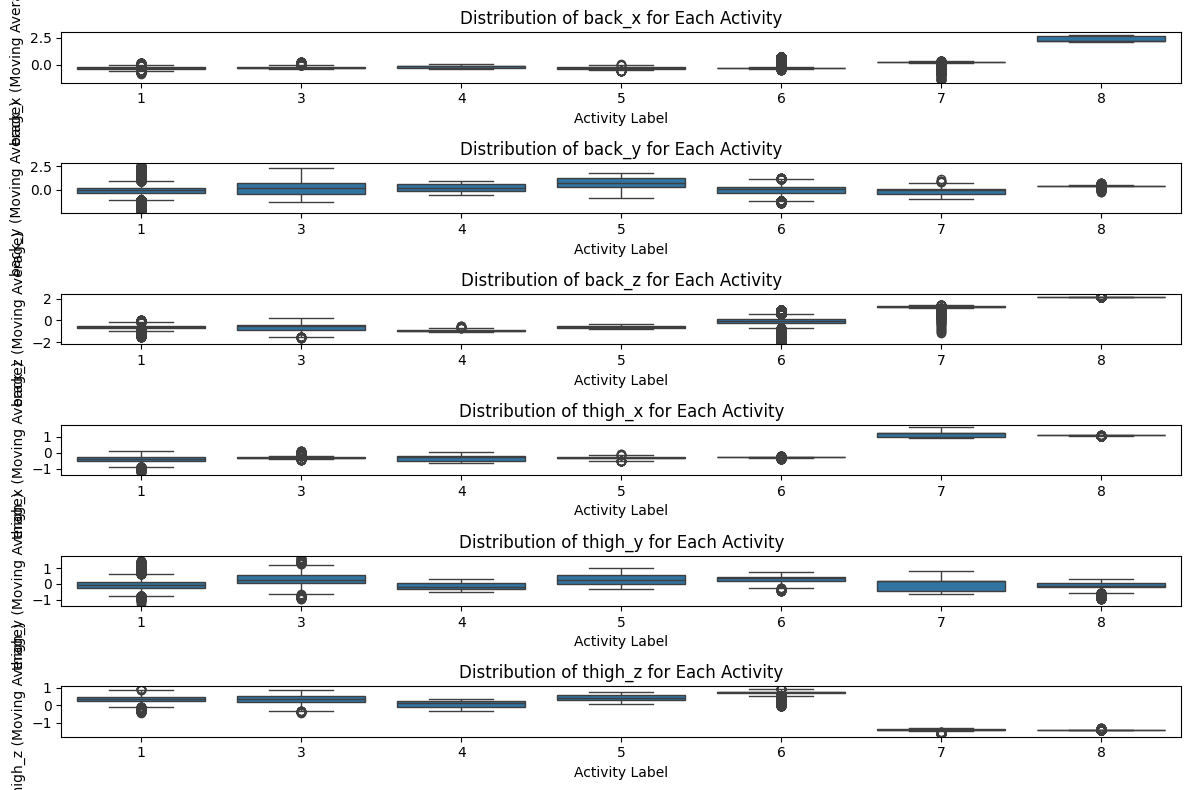

In [54]:
import seaborn as sns

plt.figure(figsize=(12, 8))

for i, sensor in enumerate(sensor_columns[:6]):
    plt.subplot(6, 1, i+1)
    sns.boxplot(x="label", y=sensor, data=df_sample)
    plt.title(f"Distribution of {sensor} for Each Activity")
    plt.xlabel("Activity Label")
    plt.ylabel(f"{sensor} (Moving Average)")

plt.tight_layout()
plt.show()


# **Feature Selection for HAR70+ Dataset**
## **Step 1: Statistical Analysis of Feature Importance**
### **Goal**
To determine which sensor readings are the most important for distinguishing activity states.  
We will use:
1. **ANOVA (Analysis of Variance):** Tests if different activities have significantly different sensor readings.
2. **Kruskal-Wallis Test:** A non-parametric alternative for non-normal data.
3. **Feature Correlation with Labels:** Measures how strongly each sensor reading relates to activity states.
4. **Random Forest Feature Importance:** Provides a direct ranking of sensor importance in classification.

---


In [55]:
from scipy.stats import f_oneway, kruskal
import pandas as pd

sensor_columns = ['back_x', 'back_z', 'thigh_x', 'thigh_z'] # based on our inspection, these sensors have highest importance, we are only checking them here

# Perform ANOVA test across activity labels for selected sensors
anova_results = {sensor: f_oneway(*[df_smoothed[df_smoothed["label"] == lbl][sensor] 
                                    for lbl in df_smoothed["label"].unique()])
                 for sensor in sensor_columns}

# Extract and display ANOVA p-values
anova_pvalues = {k: v.pvalue for k, v in anova_results.items()}
print("ANOVA p-values:", anova_pvalues)

# Perform Kruskal-Wallis test
kruskal_results = {sensor: kruskal(*[df_smoothed[df_smoothed["label"] == lbl][sensor] 
                                     for lbl in df_smoothed["label"].unique()])
                   for sensor in sensor_columns}

kruskal_pvalues = {k: v.pvalue for k, v in kruskal_results.items()}
print("Kruskal-Wallis p-values:", kruskal_pvalues)


ANOVA p-values: {'back_x': 0.0, 'back_z': 0.0, 'thigh_x': 0.0, 'thigh_z': 0.0}
Kruskal-Wallis p-values: {'back_x': 0.0, 'back_z': 0.0, 'thigh_x': 0.0, 'thigh_z': 0.0}


## **Step 2: Interpreting the Statistical Results**
Both **ANOVA** and **Kruskal-Wallis** tests evaluate whether the mean values of each sensor differ significantly across activity labels.

### **How to Interpret the p-values?**
- **p-value < 0.05:** The feature has a statistically significant difference across activities.
- **p-value ≈ 0.0:** The feature is extremely significant for distinguishing activities.
- **p-value > 0.05:** The feature is likely **not useful** for classification.

### **Our Results**
- Since all **p-values are 0.0**, we reject the null hypothesis.
- **Conclusion:** These features **significantly differ** between activity labels and are highly relevant.



## **Step 3: Correlation of Features with Activity Labels**
To further validate feature importance, we check how strongly each sensor correlates with activity labels.


In [56]:
# Compute correlation of selected sensors with activity labels
correlation_values = df_smoothed[sensor_columns].corrwith(df_smoothed["label"])


correlation_values = correlation_values.abs().sort_values(ascending=False)
print("Feature correlations with activity labels:\n", correlation_values)


Feature correlations with activity labels:
 thigh_x    0.757384
back_z     0.722276
thigh_z    0.656513
back_x     0.533205
dtype: float64


## **Step 4: Using Random Forest for Feature Importance**
To confirm our findings, we train a Random Forest classifier and measure how much each feature contributes to classification accuracy.


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare dataset for classification
X = df_smoothed[sensor_columns]
y = df_smoothed["label"]

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Extract feature importance
feature_importance = pd.Series(clf.feature_importances_, index=sensor_columns).sort_values(ascending=False)

# Display feature importance values
print("Feature Importance from Random Forest:\n", feature_importance)


Feature Importance from Random Forest:
 thigh_x    0.303914
thigh_z    0.271490
back_z     0.219665
back_x     0.204931
dtype: float64


## **Step 5: Visualizing Feature Importance**
A bar chart of feature importance scores helps us confirm which sensors are the most influential in predicting activity states.


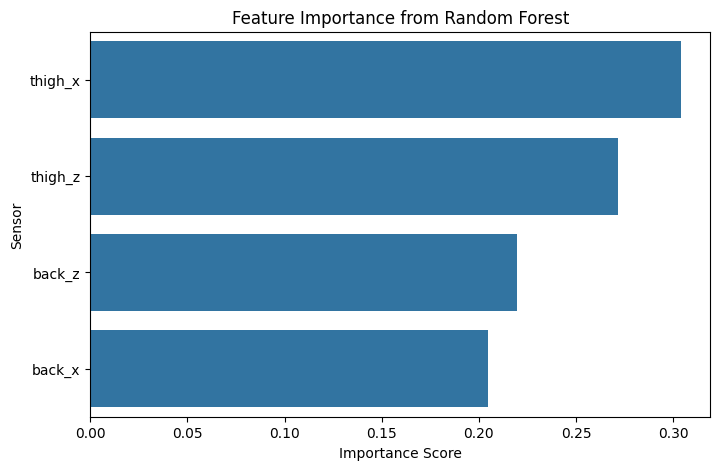

In [58]:
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Sensor")
plt.show()


# **Step: Train a Baseline Classifier (Random Forest)**
## **Goal:** Classify activities using selected important features.


In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

selected_features = ['thigh_x', 'thigh_z', 'back_z', 'back_x']
X = df_smoothed[selected_features]
y = df_smoothed["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

#Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.9526
Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.98      0.96    215863
           3       0.78      0.29      0.42     13212
           4       0.87      0.58      0.69       912
           5       0.85      0.37      0.51       996
           6       0.93      0.92      0.93     83611
           7       1.00      1.00      1.00     96690
           8       1.00      1.00      1.00     40636

    accuracy                           0.95    451920
   macro avg       0.91      0.73      0.79    451920
weighted avg       0.95      0.95      0.95    451920



## **Step: Visualize the Model Performance**
A **confusion matrix** helps us understand misclassifications.


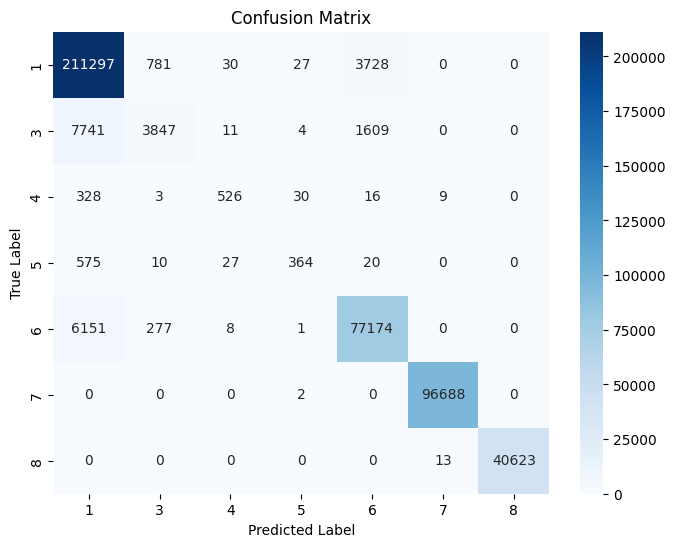

In [60]:
#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# **Step: Prepare Data for LSTM with 5Hz Sampling (down from the original 50)**
## **Goal:** Use the past 2 minutes (600 samples) to predict the next 30 seconds (150 samples).


In [61]:
# Downsample dataset: Keep only every 10th row (5Hz from 50Hz)
df_downsampled = df_smoothed.iloc[::10].reset_index(drop=True)

# Check
print(f"Original dataset size: {df_smoothed.shape}")
print(f"Downsampled dataset size (5Hz): {df_downsampled.shape}")

look_back = 600  # 2 minutes = 600 samples at 5Hz
forecast_horizon = 150  # 30 seconds = 150 samples at 5Hz

batch_size = 128


Original dataset size: (2259597, 9)
Downsampled dataset size (5Hz): (225960, 9)


## **Step: Build and Train the LSTM Model**


In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
df_downsampled["label_encoded"] = label_encoder.fit_transform(df_downsampled["label"])

selected_features = ['thigh_x', 'thigh_z', 'back_z', 'back_x']
class HARDataGenerator(Sequence):
    def __init__(self, df, features, label_col, look_back, forecast_horizon, batch_size=128):
        self.df = df
        self.features = features
        self.label_col = label_col
        self.look_back = look_back
        self.forecast_horizon = forecast_horizon
        self.batch_size = batch_size
        self.num_samples = len(df) - look_back - forecast_horizon

    def __len__(self):
        return self.num_samples // self.batch_size  # Number of batches per epoch

    def __getitem__(self, idx):
        """Loads one batch at a time"""
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size
        
        X_batch = np.zeros((self.batch_size, self.look_back, len(self.features)), dtype=np.float32)
        y_batch = np.zeros(self.batch_size, dtype=np.int32)

        for i in range(self.batch_size):
            seq_idx = start_idx + i
            X_batch[i] = self.df[self.features].values[seq_idx:seq_idx + self.look_back]
            y_batch[i] = self.df[self.label_col].iloc[seq_idx + self.look_back + self.forecast_horizon]

        y_batch = to_categorical(y_batch, num_classes=len(label_encoder.classes_))
        return X_batch, y_batch

train_size = int(0.8 * len(df_downsampled))
train_gen = HARDataGenerator(df_downsampled[:train_size], selected_features, "label_encoded", look_back, forecast_horizon, batch_size=batch_size)
val_gen = HARDataGenerator(df_downsampled[train_size:], selected_features, "label_encoded", look_back, forecast_horizon, batch_size=batch_size)

print(f"Total training batches: {len(train_gen)}")
print(f"Total validation batches: {len(val_gen)}")


Total training batches: 1406
Total validation batches: 347


## **Step: Evaluate the LSTM Model**


In [63]:
import numpy as np
import tensorflow as tf

selected_features = ['thigh_x', 'thigh_z', 'back_z', 'back_x']

class HARAccelerationGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, features, look_back, forecast_horizon, batch_size=128):
        self.df = df
        self.features = features
        self.look_back = look_back
        self.forecast_horizon = forecast_horizon
        self.batch_size = batch_size
        self.num_samples = len(df) - look_back - forecast_horizon

    def __len__(self):
        return self.num_samples // self.batch_size  # Number of batches per epoch

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size

        X_batch = np.zeros((self.batch_size, self.look_back, len(self.features)), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, len(self.features)), dtype=np.float32)  # Predict future accelerations

        for i in range(self.batch_size):
            seq_idx = start_idx + i
            X_batch[i] = self.df[self.features].values[seq_idx:seq_idx + self.look_back]
            y_batch[i] = self.df[self.features].iloc[seq_idx + self.look_back + self.forecast_horizon]  # Predict future

        return X_batch, y_batch

train_size = int(0.8 * len(df_downsampled))
train_gen_accel = HARAccelerationGenerator(df_downsampled[:train_size], selected_features, look_back, forecast_horizon, batch_size=batch_size)
val_gen_accel = HARAccelerationGenerator(df_downsampled[train_size:], selected_features, look_back, forecast_horizon, batch_size=batch_size)

print(f"Total training batches: {len(train_gen_accel)}")
print(f"Total validation batches: {len(val_gen_accel)}")


Total training batches: 1406
Total validation batches: 347


In [67]:
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define LSTM model for acceleration prediction
model_accel = tf.keras.Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, len(selected_features))),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(len(selected_features), activation='linear')  # Output future accelerations
])

# Compile model
model_accel.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Use MSE for regression

# Train model
history_accel = model_accel.fit(
    train_gen_accel,
    validation_data=val_gen_accel,
    epochs=10
)


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - loss: 0.3969 - mae: 0.3981

C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1099s 780ms/step - loss: 0.3969 - mae: 0.3981 - val_loss: 0.3614 - val_mae: 0.3459
Epoch 2/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1100s 782ms/step - loss: 0.3586 - mae: 0.3608 - val_loss: 0.3457 - val_mae: 0.3259
Epoch 3/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1094s 778ms/step - loss: 0.3539 - mae: 0.3591 - val_loss: 0.3460 - val_mae: 0.3097
Epoch 4/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1095s 779ms/step - loss: 0.3211 - mae: 0.3407 - val_loss: 0.3405 - val_mae: 0.3416
Epoch 5/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1096s 780ms/step - loss: 0.3417 - mae: 0.3548 - val_loss: 0.3441 - val_mae: 0.3661
Epoch 6/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1001s 712ms/step - loss: 0.3257 - mae: 0.3471 - val_loss: 0.3505 - val_mae: 0.3780
Epoch 7/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 978s 695ms/step - loss: 0.3197 - mae: 0.3371 - val_loss: 0.3432 - val_mae: 0.3060
Epoch 8/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 982s 699ms/step - loss: 0.3166 - mae: 0.3323 - val_loss: 0.3430 - val_mae: 0.3437
Epoch 9/10
14

In [68]:
final_train_loss = history_accel.history['loss'][-1]
final_train_mae = history_accel.history['mae'][-1]

final_val_loss = history_accel.history['val_loss'][-1]
final_val_mae = history_accel.history['val_mae'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Training MAE: {final_train_mae:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation MAE: {final_val_mae:.4f}")


Final Training Loss: 0.3288
Final Training MAE: 0.3437
Final Validation Loss: 0.3490
Final Validation MAE: 0.3356


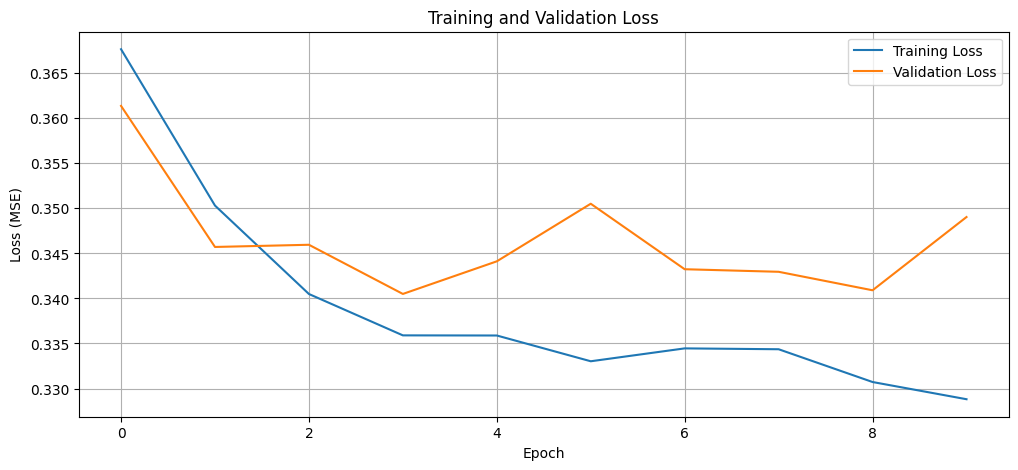

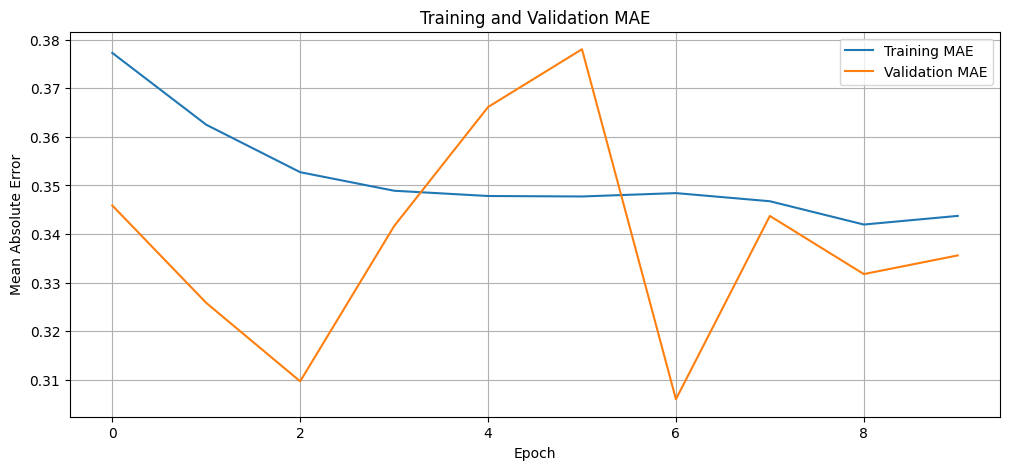

In [69]:
# Plot Loss
plt.figure(figsize=(12,5))
plt.plot(history_accel.history['loss'], label='Training Loss')
plt.plot(history_accel.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot MAE
plt.figure(figsize=(12,5))
plt.plot(history_accel.history['mae'], label='Training MAE')
plt.plot(history_accel.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid()
plt.show()


In [70]:
predicted_accelerations = model_accel.predict(val_gen_accel)

# Use the trained classifier to predict labels from accelerations
predicted_labels = clf.predict(predicted_accelerations)

# Get true labels
true_labels = []
for _, y_batch in val_gen:
    true_labels.extend(np.argmax(y_batch, axis=1))
    if len(true_labels) >= len(predicted_labels):
        break

true_labels = np.array(true_labels[:len(predicted_labels)])  # Ensure sizes match


347/347 ━━━━━━━━━━━━━━━━━━━━ 131s 377ms/step


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


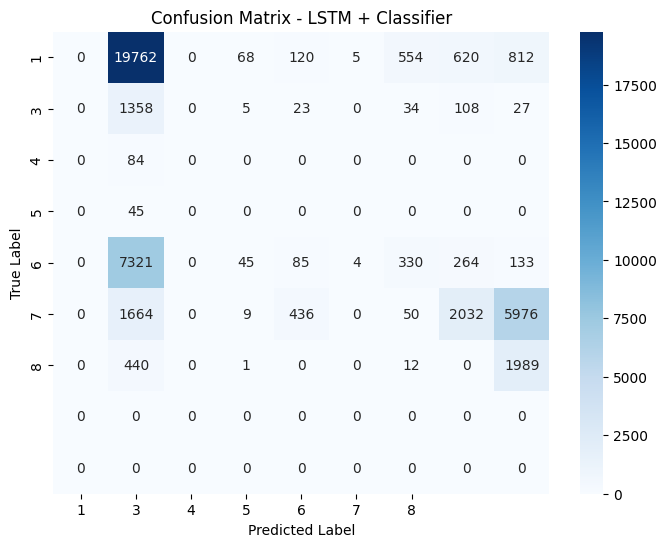

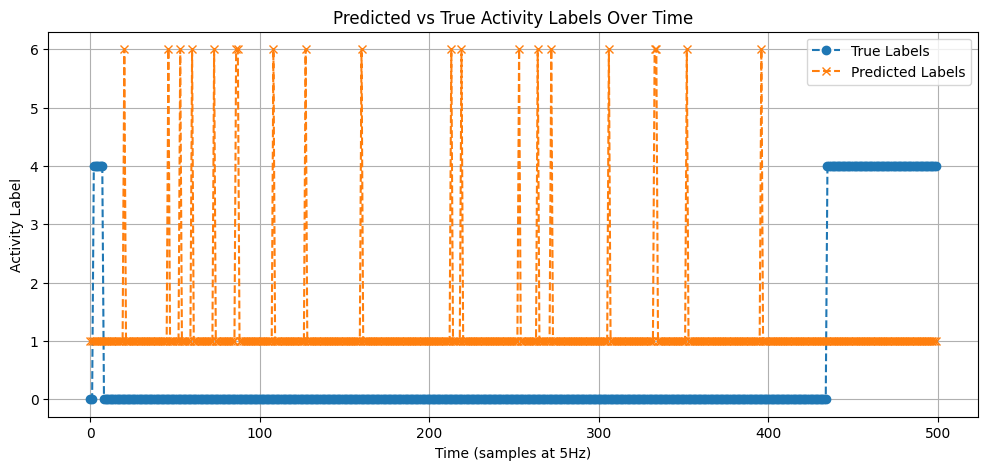

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM + Classifier")
plt.show()

time_range = 500  
y_pred_sample = predicted_labels[:time_range]
y_true_sample = true_labels[:time_range]

plt.figure(figsize=(12, 5))
plt.plot(y_true_sample, label="True Labels", linestyle='dashed', marker='o')
plt.plot(y_pred_sample, label="Predicted Labels", linestyle='dashed', marker='x')
plt.title("Predicted vs True Activity Labels Over Time")
plt.xlabel("Time (samples at 5Hz)")
plt.ylabel("Activity Label")
plt.legend()
plt.grid()
plt.show()


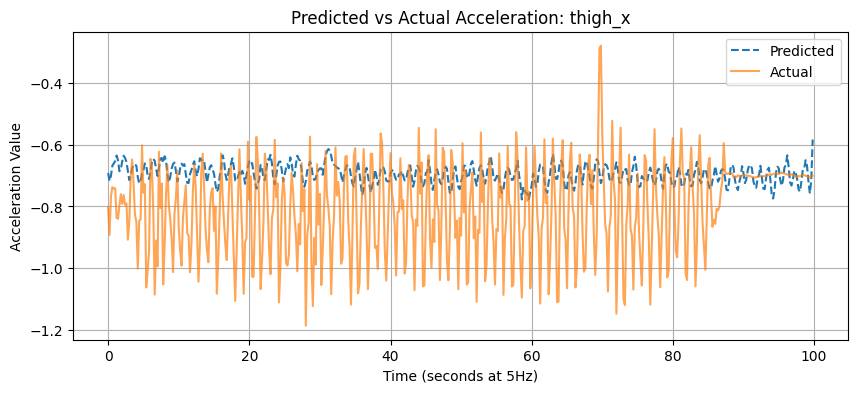

In [72]:
actual_accel_values = []

for X_batch, y_batch in val_gen_accel:
    actual_accel_values.extend(y_batch[:, 0])  # Extract first feature column
    if len(actual_accel_values) >= time_range:  # Stop when we reach 500 samples
        break

# Convert to NumPy array and match shape
actual_accel_values = np.array(actual_accel_values[:time_range])  # Trim to exactly 500

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(np.arange(time_range) / 5, predicted_accelerations[:time_range, 0], label="Predicted", linestyle="dashed")
plt.plot(np.arange(time_range) / 5, actual_accel_values, label="Actual", alpha=0.7)
plt.title(f"Predicted vs Actual Acceleration: {selected_features[0]}")
plt.xlabel("Time (seconds at 5Hz)")
plt.ylabel("Acceleration Value")
plt.legend()
plt.grid()
plt.show()


In [73]:
print(df_downsampled.columns)  # Check column names
print(df_downsampled['subject_id'].unique())  # List unique individuals


Index(['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y',
       'thigh_z', 'label', 'subject_id', 'label_encoded'],
      dtype='object')
['501' '502' '503' '504' '505' '506' '507' '508' '509' '510' '511' '512'
 '513' '514' '515' '516' '517' '518']


In [74]:
# Create dictionary to store individual datasets
individual_datasets = {subject: df_downsampled[df_downsampled['subject_id'] == subject] for subject in df_downsampled['subject_id'].unique()}

# Print dataset sizes
for subject, df in individual_datasets.items():
    print(f"Subject {subject}: {len(df)} samples")


Subject 501: 10386 samples
Subject 502: 13137 samples
Subject 503: 11641 samples
Subject 504: 15076 samples
Subject 505: 8701 samples
Subject 506: 12271 samples
Subject 507: 12013 samples
Subject 508: 13049 samples
Subject 509: 12176 samples
Subject 510: 12207 samples
Subject 511: 12806 samples
Subject 512: 11931 samples
Subject 513: 12360 samples
Subject 514: 10151 samples
Subject 515: 15351 samples
Subject 516: 13828 samples
Subject 517: 14705 samples
Subject 518: 14171 samples


In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

individual_models = {}

# Training parameters
look_back = 600  # 2 minutes at 5Hz
forecast_horizon = 150  # 30 seconds at 5Hz
batch_size = 128
epochs = 10

# Train one LSTM per individual
for subject, df_subject in individual_datasets.items():
    print(f"\n Training LSTM for Subject {subject}")

    # Create data generator for this subject
    train_gen_subject = HARAccelerationGenerator(df_subject, selected_features, look_back, forecast_horizon, batch_size=batch_size)
    
    # Define LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(look_back, len(selected_features))),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(len(selected_features), activation='linear')  # Predict accelerations
    ])
    
    # Compile model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train model
    model.fit(train_gen_subject, epochs=epochs)
    
    # Store model
    individual_models[subject] = model

print("\n Finished training all individual models!")



 Training LSTM for Subject 501
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 591ms/step - loss: 0.3192 - mae: 0.3863
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 588ms/step - loss: 0.3953 - mae: 0.4145
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 589ms/step - loss: 0.2496 - mae: 0.3182
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 588ms/step - loss: 0.2285 - mae: 0.3002
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 589ms/step - loss: 0.3037 - mae: 0.3513
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 587ms/step - loss: 0.3571 - mae: 0.3880
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 587ms/step - loss: 0.2596 - mae: 0.3246
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 590ms/step - loss: 0.2310 - mae: 0.3002
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 591ms/step - loss: 0.3022 - mae: 0.3451
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 590ms/step - loss: 0.2245 - mae: 0.2867

 Training LSTM for Subject 502
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 585ms/step - loss: 0.4200 - mae: 0.4097
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 584ms/step - loss: 0.2962 - mae: 0.3234
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 584ms/step - loss: 0.2040 - mae: 0.2739
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 585ms/step - loss: 0.2854 - mae: 0.3117
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 589ms/step - loss: 0.2680 - mae: 0.3135
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 590ms/step - loss: 0.1979 - mae: 0.2669
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 589ms/step - loss: 0.2578 - mae: 0.2876
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 588ms/step - loss: 0.1362 - mae: 0.2152
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 588ms/step - loss: 0.1963 - mae: 0.2560
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 590ms/step - loss: 0.1993 - mae: 0.2524

 Training LSTM for Subject 503
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 52s 589ms/step - loss: 0.6081 - mae: 0.5680
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 589ms/step - loss: 0.4412 - mae: 0.4237
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 590ms/step - loss: 0.3303 - mae: 0.4081
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 587ms/step - loss: 0.3366 - mae: 0.3728
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 591ms/step - loss: 0.3395 - mae: 0.3696
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 591ms/step - loss: 0.3549 - mae: 0.4048
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 589ms/step - loss: 0.2910 - mae: 0.3425
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 589ms/step - loss: 0.2866 - mae: 0.3360
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 51s 603ms/step - loss: 0.3201 - mae: 0.3731
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 51s 596ms/step - loss: 0.3918 - mae: 0.4216

 Training LSTM for Subject 504
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 68s 595ms/step - loss: 0.4598 - mae: 0.4048
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 66s 596ms/step - loss: 0.4765 - mae: 0.3886
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 66s 592ms/step - loss: 0.2806 - mae: 0.2806
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 66s 591ms/step - loss: 0.3142 - mae: 0.3239
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 66s 595ms/step - loss: 0.3903 - mae: 0.3484
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 66s 591ms/step - loss: 0.3636 - mae: 0.3380
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 66s 591ms/step - loss: 0.2729 - mae: 0.3032
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 66s 590ms/step - loss: 0.2985 - mae: 0.3088
Epoch 9/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 66s 592ms/step - loss: 0.2923 - mae: 0.3050
Epoch 10/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 66s 592ms/step - loss: 0.2650 - mae: 0.2866

 Training LSTM for Subject 505
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 589ms/step - loss: 0.6607 - mae: 0.6374
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 594ms/step - loss: 0.6464 - mae: 0.5866
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 588ms/step - loss: 0.5915 - mae: 0.5464
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 588ms/step - loss: 0.2760 - mae: 0.3161
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 588ms/step - loss: 0.3403 - mae: 0.4314
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 587ms/step - loss: 0.4390 - mae: 0.5206
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 590ms/step - loss: 0.4617 - mae: 0.4459
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 589ms/step - loss: 0.4748 - mae: 0.4611
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 593ms/step - loss: 0.2644 - mae: 0.3294
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 593ms/step - loss: 0.4624 - mae: 0.4799

 Training LSTM for Subject 506
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 608ms/step - loss: 0.3813 - mae: 0.3980
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 606ms/step - loss: 0.2400 - mae: 0.3066
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 607ms/step - loss: 0.2861 - mae: 0.3240
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 605ms/step - loss: 0.1440 - mae: 0.2237
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 607ms/step - loss: 0.2571 - mae: 0.3373
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 610ms/step - loss: 0.3376 - mae: 0.3372
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 610ms/step - loss: 0.2674 - mae: 0.3198
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 606ms/step - loss: 0.1492 - mae: 0.2242
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 608ms/step - loss: 0.1403 - mae: 0.2301
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 605ms/step - loss: 0.2165 - mae: 0.2969

 Training LSTM for Subject 507
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 55s 610ms/step - loss: 0.4098 - mae: 0.4058
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 611ms/step - loss: 0.4384 - mae: 0.4016
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 54s 616ms/step - loss: 0.4228 - mae: 0.3723
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 612ms/step - loss: 0.4782 - mae: 0.3978
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 611ms/step - loss: 0.3528 - mae: 0.3442
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 609ms/step - loss: 0.2245 - mae: 0.2706
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 613ms/step - loss: 0.3276 - mae: 0.3430
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 612ms/step - loss: 0.3373 - mae: 0.3110
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 612ms/step - loss: 0.1905 - mae: 0.2401
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 614ms/step - loss: 0.3687 - mae: 0.3467

 Training LSTM for Subject 508
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 720ms/step - loss: 0.5194 - mae: 0.5129
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 717ms/step - loss: 0.2808 - mae: 0.3097
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 720ms/step - loss: 0.2295 - mae: 0.2922
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 718ms/step - loss: 0.1808 - mae: 0.2805
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 720ms/step - loss: 0.3149 - mae: 0.3501
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 722ms/step - loss: 0.2971 - mae: 0.3109
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 720ms/step - loss: 0.3242 - mae: 0.3361
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 718ms/step - loss: 0.2193 - mae: 0.2769
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 721ms/step - loss: 0.1852 - mae: 0.2552
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 721ms/step - loss: 0.1621 - mae: 0.2459

 Training LSTM for Subject 509
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 66s 718ms/step - loss: 0.3191 - mae: 0.4140
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 64s 714ms/step - loss: 0.2534 - mae: 0.3413
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 64s 714ms/step - loss: 0.1943 - mae: 0.2799
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 64s 714ms/step - loss: 0.1462 - mae: 0.2453
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 64s 716ms/step - loss: 0.2754 - mae: 0.3399
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 64s 717ms/step - loss: 0.1598 - mae: 0.2481
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 64s 713ms/step - loss: 0.2024 - mae: 0.2813
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 64s 713ms/step - loss: 0.2204 - mae: 0.2920
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 712ms/step - loss: 0.1971 - mae: 0.2894
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 64s 716ms/step - loss: 0.1426 - mae: 0.2454

 Training LSTM for Subject 510
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 65s 710ms/step - loss: 0.7493 - mae: 0.6347
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 709ms/step - loss: 0.2586 - mae: 0.3247
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 710ms/step - loss: 0.2735 - mae: 0.3397
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 708ms/step - loss: 0.2456 - mae: 0.3313
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 707ms/step - loss: 0.3501 - mae: 0.3747
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 708ms/step - loss: 0.1933 - mae: 0.2706
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 709ms/step - loss: 0.3298 - mae: 0.3716
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 710ms/step - loss: 0.4711 - mae: 0.4041
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 707ms/step - loss: 0.3545 - mae: 0.3727
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 708ms/step - loss: 0.2986 - mae: 0.3385

 Training LSTM for Subject 511
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 702ms/step - loss: 0.6912 - mae: 0.5952
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 702ms/step - loss: 0.3497 - mae: 0.3893
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 704ms/step - loss: 0.2450 - mae: 0.3147
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 703ms/step - loss: 0.3196 - mae: 0.3739
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 701ms/step - loss: 0.2110 - mae: 0.2698
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 702ms/step - loss: 0.3136 - mae: 0.3870
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 703ms/step - loss: 0.3052 - mae: 0.3245
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 704ms/step - loss: 0.2004 - mae: 0.2740
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 703ms/step - loss: 0.2308 - mae: 0.3012
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 703ms/step - loss: 0.2180 - mae: 0.2888

 Training LSTM for Subject 512
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 62s 688ms/step - loss: 0.7081 - mae: 0.4862
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 688ms/step - loss: 0.5310 - mae: 0.3972
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 689ms/step - loss: 0.4481 - mae: 0.3777
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 698ms/step - loss: 0.4173 - mae: 0.3835
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 698ms/step - loss: 0.3081 - mae: 0.3403
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 696ms/step - loss: 0.3635 - mae: 0.3622
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 693ms/step - loss: 0.5089 - mae: 0.4552
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 696ms/step - loss: 0.3868 - mae: 0.3845
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 697ms/step - loss: 0.5542 - mae: 0.4208
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 702ms/step - loss: 0.5246 - mae: 0.3798

 Training LSTM for Subject 513
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 64s 699ms/step - loss: 0.7056 - mae: 0.6115
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 694ms/step - loss: 0.4595 - mae: 0.4646
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 694ms/step - loss: 0.4481 - mae: 0.4446
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 698ms/step - loss: 0.4998 - mae: 0.4688
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 696ms/step - loss: 0.5047 - mae: 0.4813
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 696ms/step - loss: 0.4023 - mae: 0.4295
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 697ms/step - loss: 0.5680 - mae: 0.4863
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 695ms/step - loss: 0.4595 - mae: 0.4328
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 695ms/step - loss: 0.3850 - mae: 0.4153
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 696ms/step - loss: 0.5031 - mae: 0.4822

 Training LSTM for Subject 514
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 53s 705ms/step - loss: 0.8408 - mae: 0.6320
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 52s 709ms/step - loss: 0.6803 - mae: 0.6209
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 52s 705ms/step - loss: 0.4877 - mae: 0.4728
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 52s 706ms/step - loss: 0.6543 - mae: 0.5371
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 51s 701ms/step - loss: 0.8219 - mae: 0.6450
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 51s 701ms/step - loss: 0.6989 - mae: 0.5472
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 51s 704ms/step - loss: 0.4122 - mae: 0.3899
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 52s 705ms/step - loss: 0.6040 - mae: 0.5817
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 52s 705ms/step - loss: 0.6280 - mae: 0.5021
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 52s 705ms/step - loss: 0.5606 - mae: 0.4988

 Training LSTM for Subject 515
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 82s 705ms/step - loss: 0.5799 - mae: 0.5733
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 704ms/step - loss: 0.3368 - mae: 0.3657
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 704ms/step - loss: 0.3056 - mae: 0.3621
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 703ms/step - loss: 0.3297 - mae: 0.3856
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 701ms/step - loss: 0.2877 - mae: 0.3310
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 702ms/step - loss: 0.2341 - mae: 0.3113
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 699ms/step - loss: 0.3115 - mae: 0.3504
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 704ms/step - loss: 0.2347 - mae: 0.3066
Epoch 9/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 703ms/step - loss: 0.3471 - mae: 0.3831
Epoch 10/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 698ms/step - loss: 0.3826 - mae: 0.3684

 Training LSTM for Subject 516
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 72s 693ms/step - loss: 0.7901 - mae: 0.5149
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 697ms/step - loss: 0.4336 - mae: 0.3809
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 699ms/step - loss: 0.3466 - mae: 0.3424
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 698ms/step - loss: 0.5944 - mae: 0.4668
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 695ms/step - loss: 0.4477 - mae: 0.3891
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 694ms/step - loss: 0.4665 - mae: 0.3896
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 694ms/step - loss: 0.4615 - mae: 0.4171
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 697ms/step - loss: 0.4368 - mae: 0.3493
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 693ms/step - loss: 0.4171 - mae: 0.3696
Epoch 10/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 70s 690ms/step - loss: 0.4603 - mae: 0.3869

 Training LSTM for Subject 517
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 77s 693ms/step - loss: 0.5828 - mae: 0.5535
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 697ms/step - loss: 0.4160 - mae: 0.4272
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 696ms/step - loss: 0.5234 - mae: 0.4967
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 695ms/step - loss: 0.4512 - mae: 0.4479
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 692ms/step - loss: 0.4187 - mae: 0.4253
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 697ms/step - loss: 0.3871 - mae: 0.4005
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 687ms/step - loss: 0.3471 - mae: 0.3711
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 693ms/step - loss: 0.4945 - mae: 0.4803
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 693ms/step - loss: 0.3866 - mae: 0.4092
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 692ms/step - loss: 0.4657 - mae: 0.4536

 Training LSTM for Subject 518
Epoch 1/10


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 684ms/step - loss: 0.4003 - mae: 0.4696
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 71s 684ms/step - loss: 0.2402 - mae: 0.3156
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 691ms/step - loss: 0.2233 - mae: 0.2804
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 691ms/step - loss: 0.1923 - mae: 0.2862
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 691ms/step - loss: 0.2014 - mae: 0.2715
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 692ms/step - loss: 0.3439 - mae: 0.3847
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 692ms/step - loss: 0.3896 - mae: 0.3978
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 691ms/step - loss: 0.2499 - mae: 0.2955
Epoch 9/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 691ms/step - loss: 0.2816 - mae: 0.3474
Epoch 10/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 692ms/step - loss: 0.3166 - mae: 0.3525

 Finished training all individual models!


In [76]:
from sklearn.ensemble import RandomForestClassifier

individual_classifiers = {}

for subject, df_subject in individual_datasets.items():
    print(f"\n Training Classifier for Subject {subject}")

    # Extract training data
    X = df_subject[selected_features]
    y = df_subject["label"]

    # Train a classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)

    # Store model
    individual_classifiers[subject] = clf

print("\n Finished training all individual classifiers!")



 Training Classifier for Subject 501

 Training Classifier for Subject 502

 Training Classifier for Subject 503

 Training Classifier for Subject 504

 Training Classifier for Subject 505

 Training Classifier for Subject 506

 Training Classifier for Subject 507

 Training Classifier for Subject 508

 Training Classifier for Subject 509

 Training Classifier for Subject 510

 Training Classifier for Subject 511

 Training Classifier for Subject 512

 Training Classifier for Subject 513

 Training Classifier for Subject 514

 Training Classifier for Subject 515

 Training Classifier for Subject 516

 Training Classifier for Subject 517

 Training Classifier for Subject 518

 Finished training all individual classifiers!


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step


C:\Users\adami\anaconda3\envs\Ali_USD\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


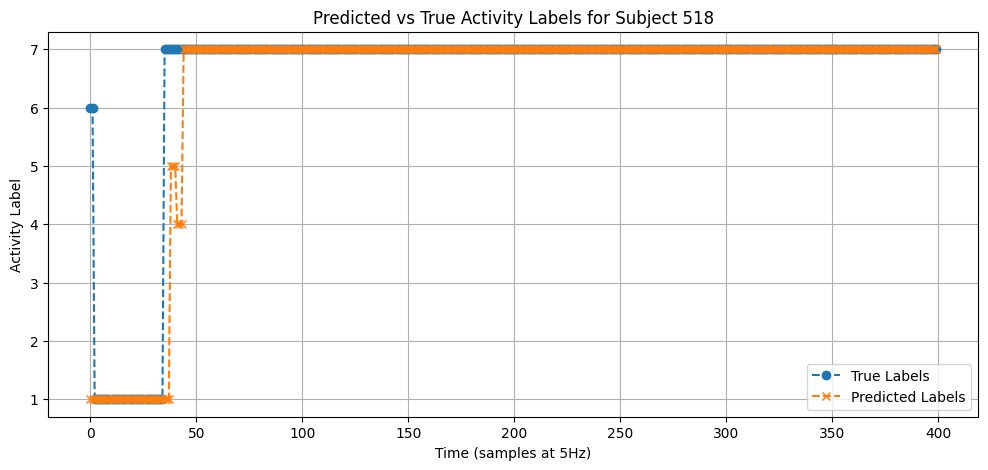

In [77]:
# Select a test subject between 501 to 518
test_subject = '518'

lstm_model = individual_models[test_subject]
classifier = individual_classifiers[test_subject]

df_test = individual_datasets[test_subject].iloc[:1000]

# Predict future accelerations using LSTM
X_test_lstm = np.array([df_test[selected_features].values[i : i + look_back] for i in range(len(df_test) - look_back)])
predicted_accelerations = lstm_model.predict(X_test_lstm)

# Predict activity labels using classifier
predicted_labels = classifier.predict(predicted_accelerations)

# Compare to true labels
true_labels = df_test["label"].iloc[look_back:].values

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(true_labels, label="True Labels", linestyle='dashed', marker='o')
plt.plot(predicted_labels, label="Predicted Labels", linestyle='dashed', marker='x')
plt.title(f"Predicted vs True Activity Labels for Subject {test_subject}")
plt.xlabel("Time (samples at 5Hz)")
plt.ylabel("Activity Label")
plt.legend()
plt.grid()
plt.show()


In [78]:
# Directory to save confusion matrix plots
conf_matrix_dir = "individual_confusion_matrices/"
if not os.path.exists(conf_matrix_dir):
    os.makedirs(conf_matrix_dir)

# Generate confusion matrix for each individual
for subject, df_subject in individual_datasets.items():
    print(f"\n Generating Confusion Matrix for Subject {subject}")
    classifier = individual_classifiers[subject]
    X_full_lstm = np.array([df_subject[selected_features].values[i : i + look_back] 
                             for i in range(len(df_subject) - look_back)])

    predicted_accelerations = individual_models[subject].predict(X_full_lstm)
    predicted_accelerations_df = pd.DataFrame(predicted_accelerations, columns=selected_features)
    predicted_labels = classifier.predict(predicted_accelerations_df)
    true_labels = df_subject["label"].iloc[look_back:].values
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Subject {subject}")

    conf_matrix_filename = f"{conf_matrix_dir}subject_{subject}_confusion_matrix.png"
    plt.savefig(conf_matrix_filename)
    plt.close()




 Generating Confusion Matrix for Subject 501
306/306 ━━━━━━━━━━━━━━━━━━━━ 72s 235ms/step

 Generating Confusion Matrix for Subject 502
392/392 ━━━━━━━━━━━━━━━━━━━━ 91s 233ms/step

 Generating Confusion Matrix for Subject 503
346/346 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step

 Generating Confusion Matrix for Subject 504
453/453 ━━━━━━━━━━━━━━━━━━━━ 102s 225ms/step

 Generating Confusion Matrix for Subject 505
254/254 ━━━━━━━━━━━━━━━━━━━━ 57s 224ms/step

 Generating Confusion Matrix for Subject 506
365/365 ━━━━━━━━━━━━━━━━━━━━ 81s 220ms/step

 Generating Confusion Matrix for Subject 507
357/357 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step

 Generating Confusion Matrix for Subject 508
390/390 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step

 Generating Confusion Matrix for Subject 509
362/362 ━━━━━━━━━━━━━━━━━━━━ 80s 221ms/step

 Generating Confusion Matrix for Subject 510
363/363 ━━━━━━━━━━━━━━━━━━━━ 80s 221ms/step

 Generating Confusion Matrix for Subject 511
382/382 ━━━━━━━━━━━━━━━━━━━━ 91s 237ms/step

 Generat

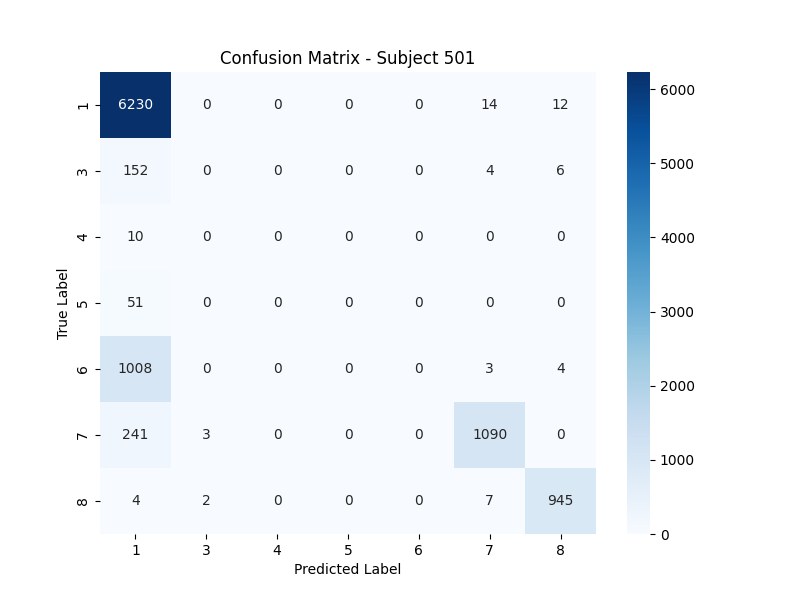

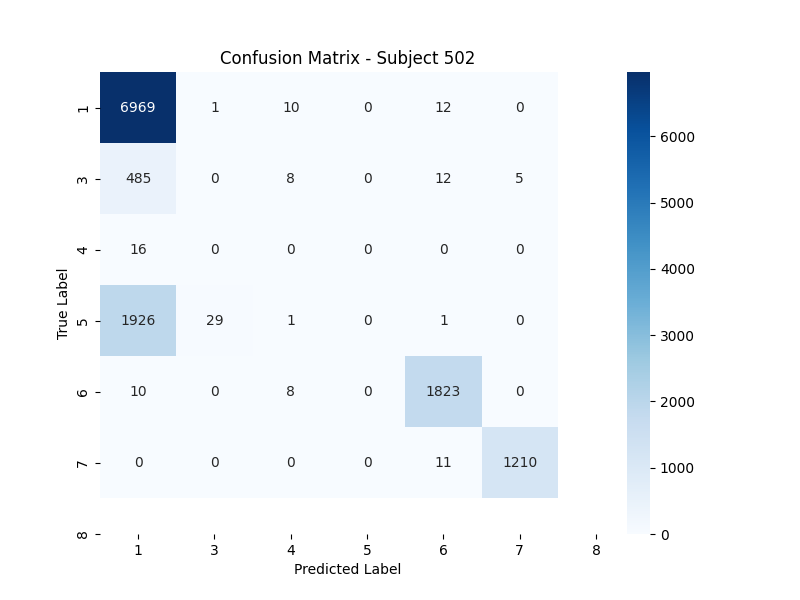

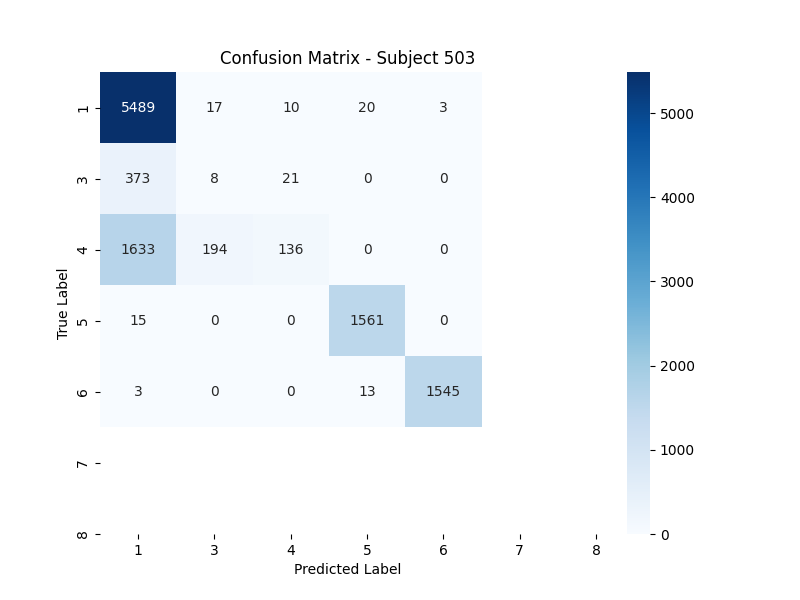

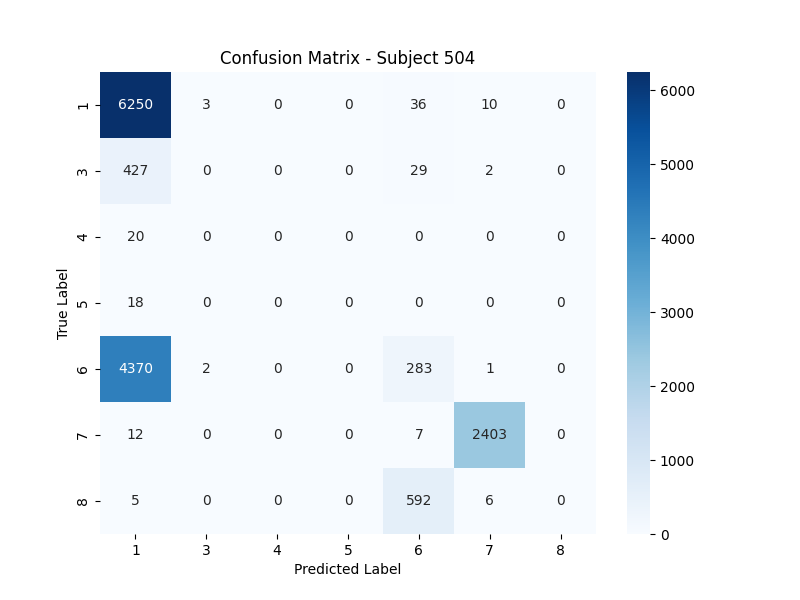

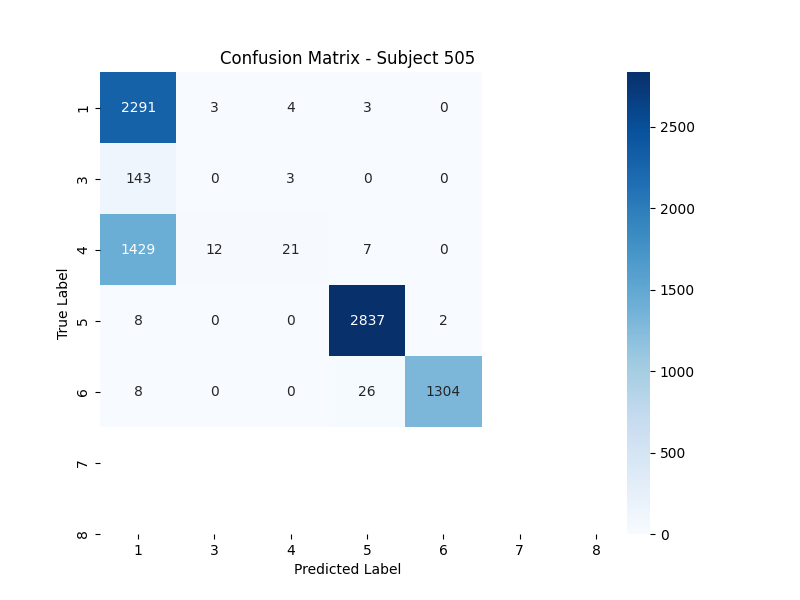

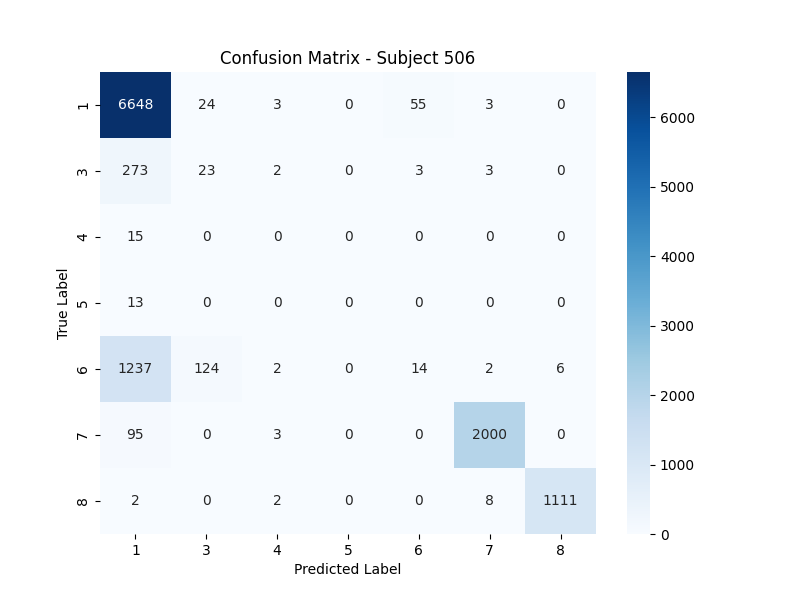

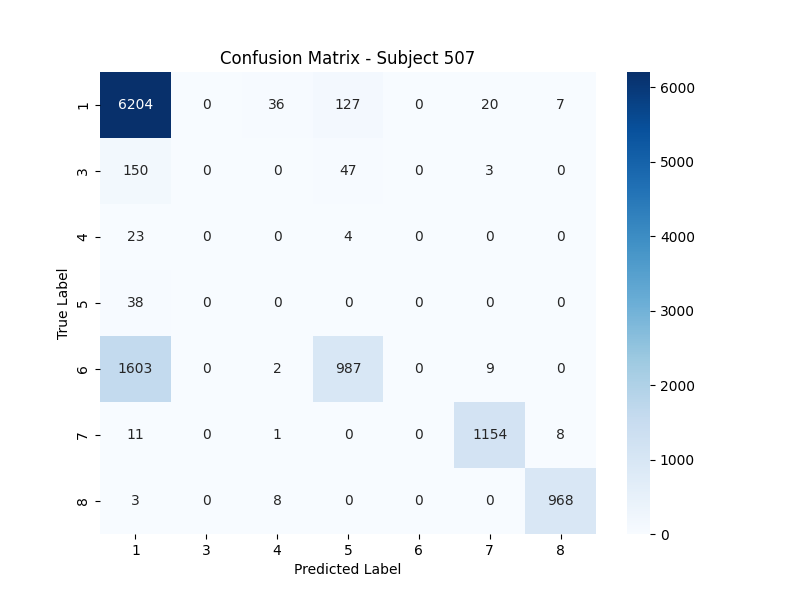

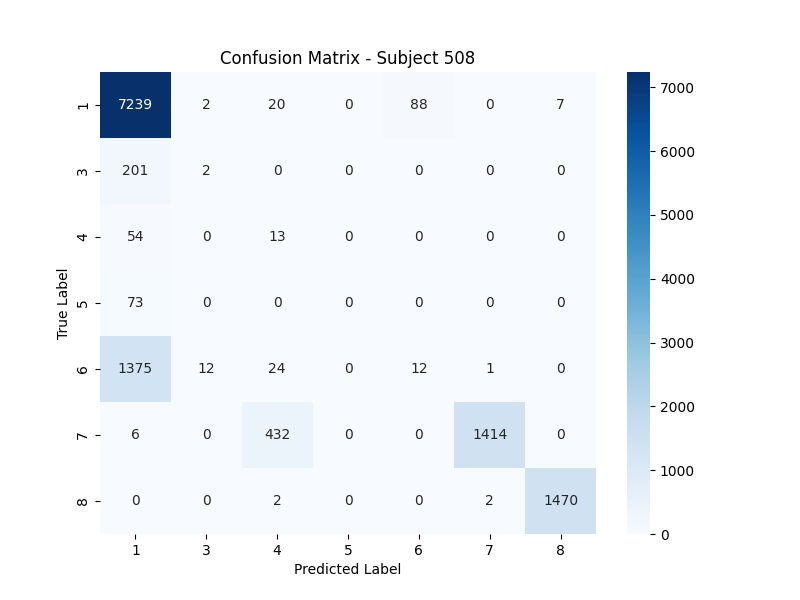

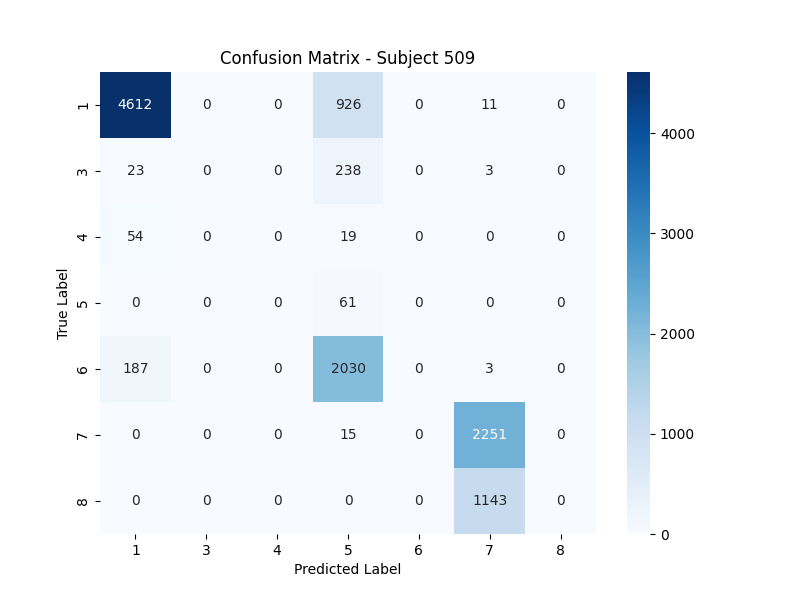

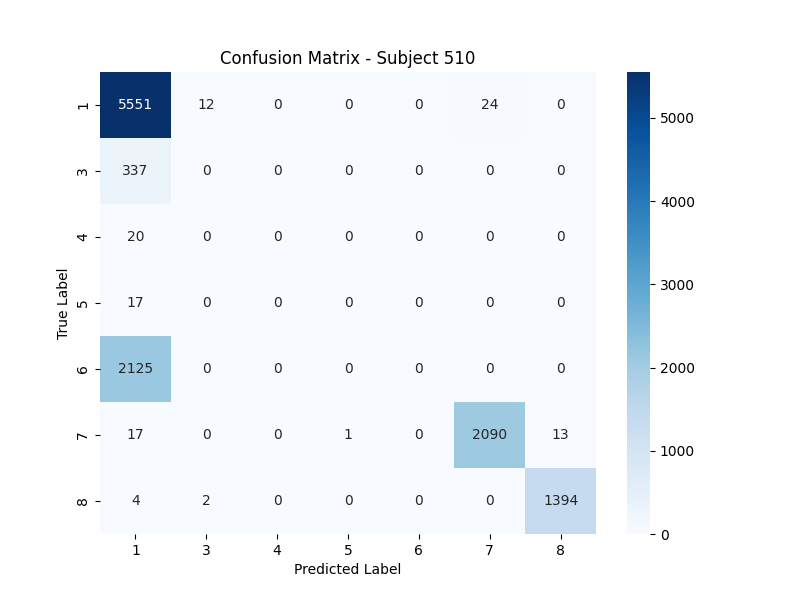

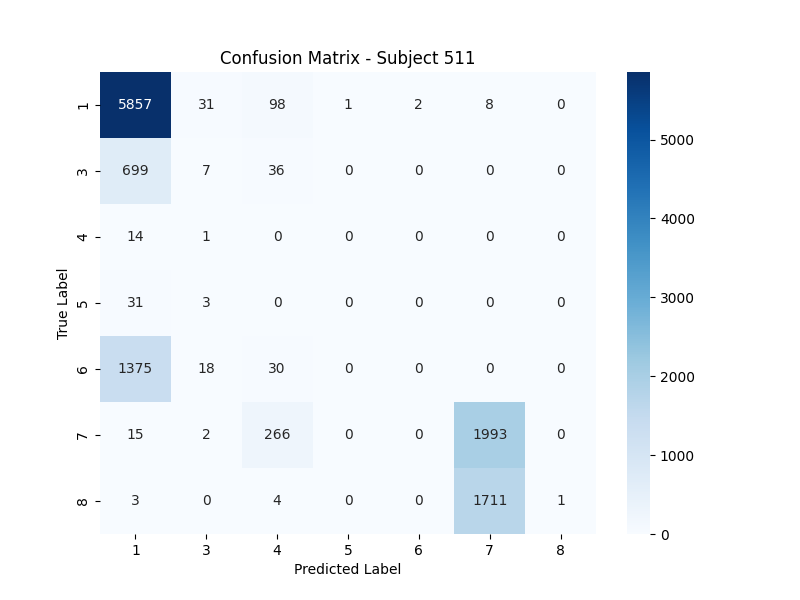

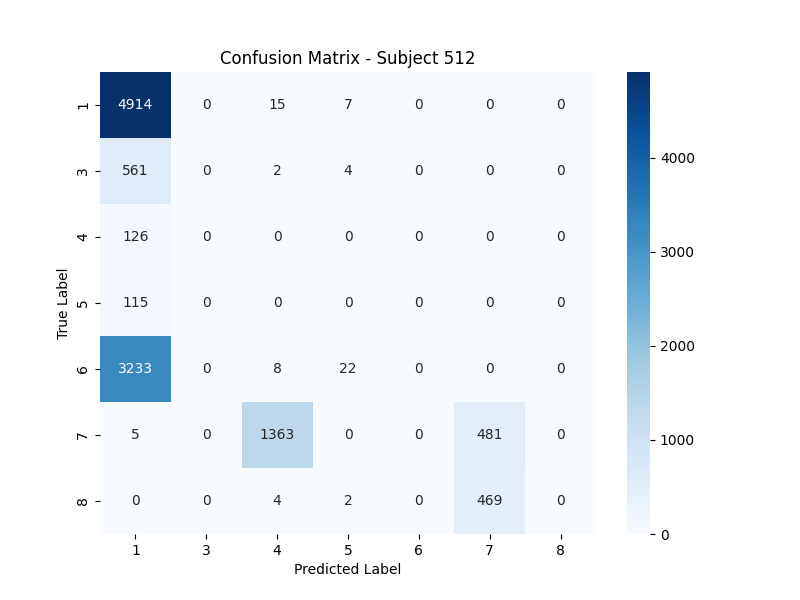

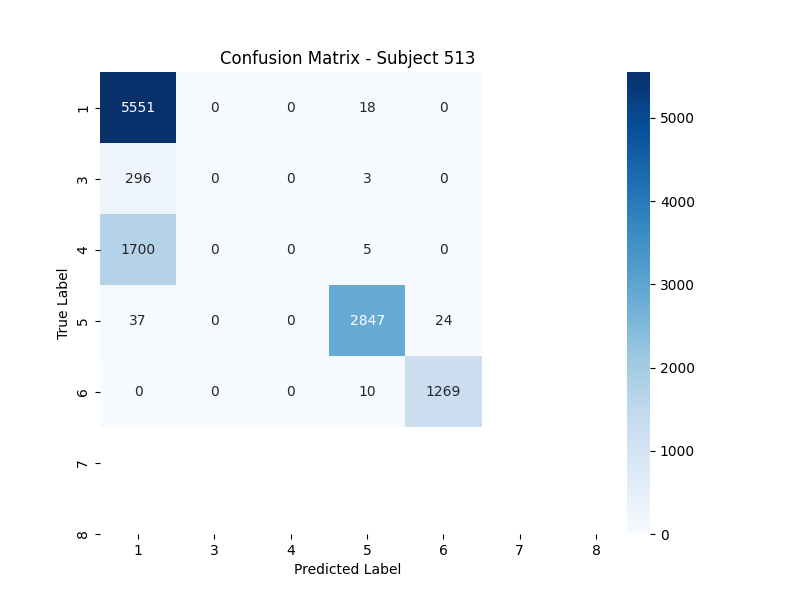

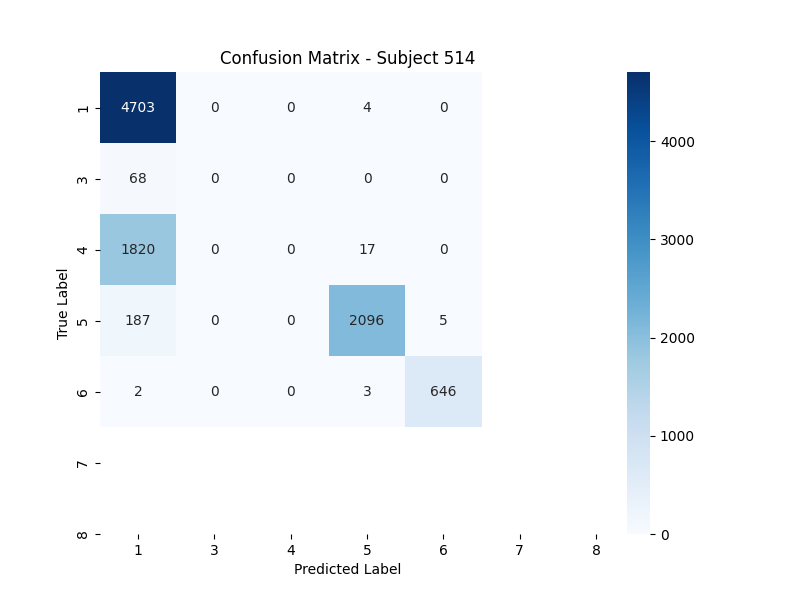

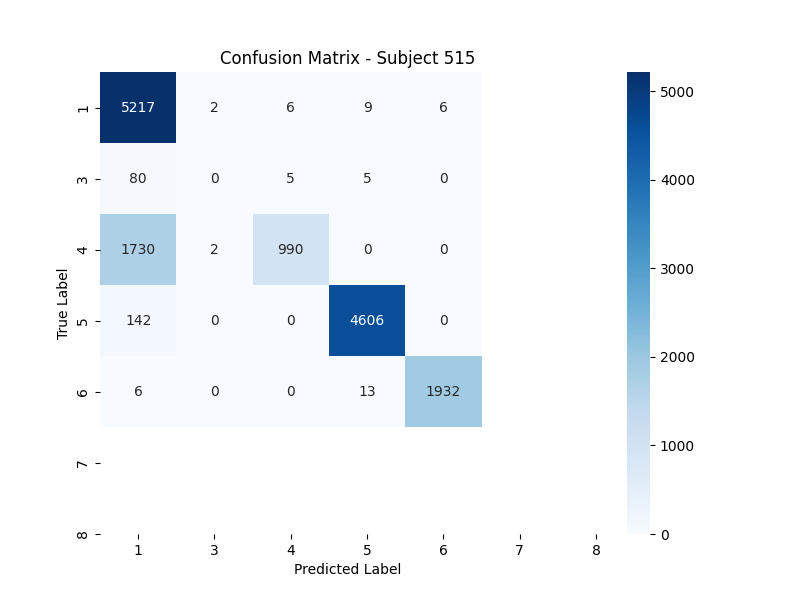

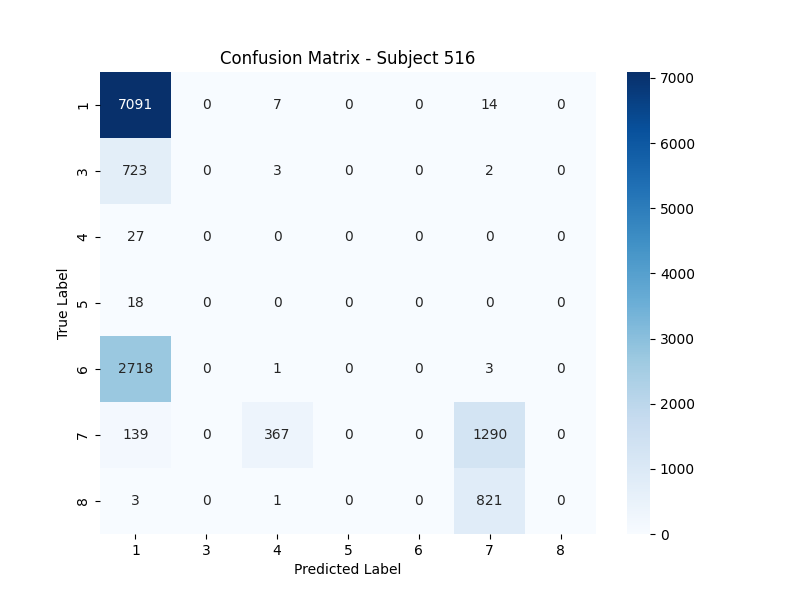

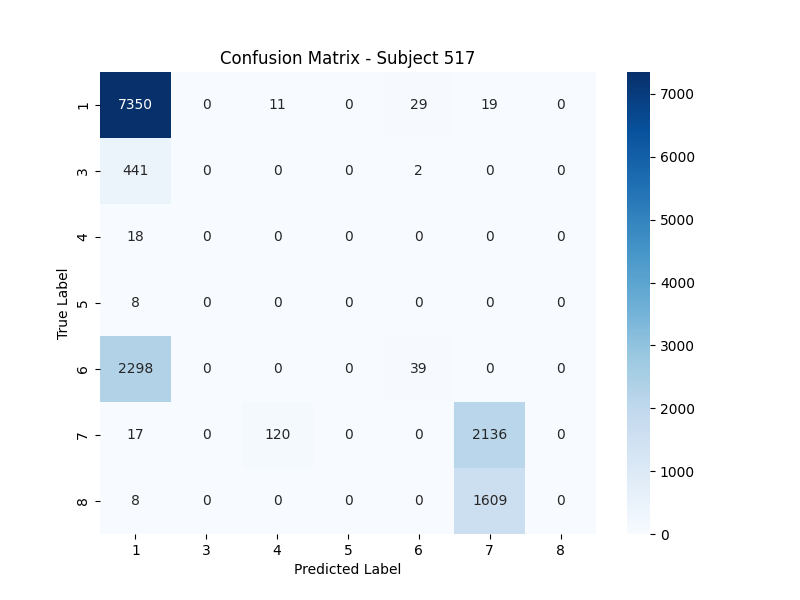

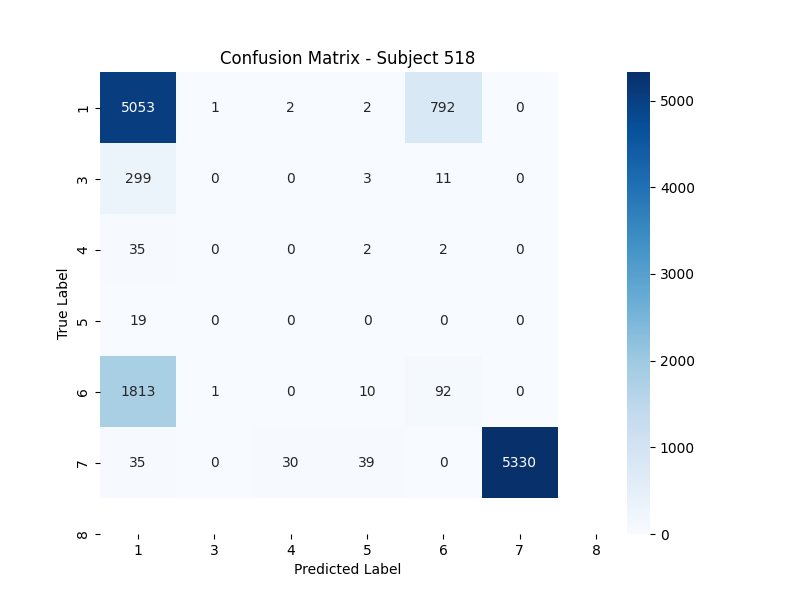

In [79]:
from IPython.display import display
from PIL import Image
import os

conf_matrix_images = sorted(os.listdir(conf_matrix_dir))

for img_filename in conf_matrix_images:
    img_path = os.path.join(conf_matrix_dir, img_filename)
    display(Image.open(img_path))


In [80]:
## Saving the results to be used in IoT interface, individually for each subject.

import pandas as pd
import numpy as np
import os

output_dir = "individual_predictions/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
for subject, df_subject in individual_datasets.items():
    lstm_model = individual_models[subject]
    classifier = individual_classifiers[subject]

    X_full_lstm = np.array([df_subject[selected_features].values[i : i + look_back] 
                             for i in range(len(df_subject) - look_back)])
    
    predicted_accelerations = lstm_model.predict(X_full_lstm)
    predicted_accelerations_df = pd.DataFrame(predicted_accelerations, columns=selected_features)
    predicted_labels = classifier.predict(predicted_accelerations_df)
    actual_accelerations = df_subject[selected_features].iloc[look_back:].values
    actual_labels = df_subject["label"].iloc[look_back:].values

    # Create a time column (5Hz intervals)
    time_seconds = np.arange(len(actual_labels)) / 5  

    df_results = pd.DataFrame({
        "Time (s)": time_seconds,
        "Actual Label": actual_labels,
        "Predicted Label": predicted_labels
    })

    for i, feature in enumerate(selected_features):
        df_results[f"Actual {feature}"] = actual_accelerations[:, i]
        df_results[f"Predicted {feature}"] = predicted_accelerations[:, i]

    # Save to CSV
    csv_filename = f"{output_dir}subject_{subject}_full_predictions.csv"
    df_results.to_csv(csv_filename, index=False)
    print(f" Saved FULL dataset predictions for Subject {subject} to {csv_filename}")


306/306 ━━━━━━━━━━━━━━━━━━━━ 69s 225ms/step
 Saved FULL dataset predictions for Subject 501 to individual_predictions/subject_501_full_predictions.csv
392/392 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step
 Saved FULL dataset predictions for Subject 502 to individual_predictions/subject_502_full_predictions.csv
346/346 ━━━━━━━━━━━━━━━━━━━━ 75s 217ms/step
 Saved FULL dataset predictions for Subject 503 to individual_predictions/subject_503_full_predictions.csv
453/453 ━━━━━━━━━━━━━━━━━━━━ 101s 223ms/step
 Saved FULL dataset predictions for Subject 504 to individual_predictions/subject_504_full_predictions.csv
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 217ms/step
 Saved FULL dataset predictions for Subject 505 to individual_predictions/subject_505_full_predictions.csv
365/365 ━━━━━━━━━━━━━━━━━━━━ 78s 214ms/step
 Saved FULL dataset predictions for Subject 506 to individual_predictions/subject_506_full_predictions.csv
357/357 ━━━━━━━━━━━━━━━━━━━━ 76s 213ms/step
 Saved FULL dataset predictions for Subject 507 t